In [90]:
import os
import json
from time import sleep

import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, normalize
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from folium.plugins import HeatMap, MarkerCluster

In [ ]:
#DATA CLEANING

In [1]:
#Loading and Geocoding the data raw data 
with open('eventbrite_events_2023-08-02.json', 'r') as f:
    data = json.load(f)

df = pd.json_normalize(data)
df['datetime_local'] = pd.to_datetime(df['datetime_local'], errors='coerce')
df = df.dropna(subset=['datetime_local'])
df.drop_duplicates(subset=['event_id'], inplace=True)


for col in ['event_category', 'event_subcategory', 'city', 'state']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower()


unique_locs = df[['city', 'state']].dropna().drop_duplicates()


geolocator = Nominatim(user_agent="event_hotspot_analysis")
coords_map = {}

for index, row in unique_locs.iterrows():
    city, state = row['city'], row['state']
    key = (city, state)
    try:
        print(f"Geocoding {city}, {state}...")
        location = geolocator.geocode(f"{city}, {state}, USA")
        if location:
            coords_map[key] = (location.latitude, location.longitude)
            print(f" → Found: ({location.latitude}, {location.longitude})")
        else:
            coords_map[key] = (np.nan, np.nan)
            print(" → Not found.")
    except Exception as e:
        coords_map[key] = (np.nan, np.nan)
        print(f" → Error: {e}")
    sleep(1)  # Delay for rate limiting


df['coords'] = df.apply(lambda row: coords_map.get((row['city'], row['state']), (np.nan, np.nan)), axis=1)
df['latitude'] = df['coords'].apply(lambda x: x[0])
df['longitude'] = df['coords'].apply(lambda x: x[1])
df.drop(columns='coords', inplace=True)


df.dropna(subset=['latitude', 'longitude'], inplace=True)


df.to_json('cleaned_events_with_coords.json', orient='records', indent=2)

print("Cleaned and geocoded data saved to 'cleaned_events_with_coords.json'")

Geocoding los angeles, ca...
 → Found: (34.0536909, -118.242766)
Geocoding detroit, mi...
 → Found: (42.3315509, -83.0466403)
Geocoding atlanta, ga...
 → Found: (33.7489924, -84.3902644)
Geocoding austin, tx...
 → Found: (30.2711286, -97.7436995)
Geocoding san diego, ca...
 → Found: (32.7174202, -117.162772)
Geocoding studio city, ca...
 → Found: (34.1483989, -118.3961877)
Geocoding salt lake city, ut...
 → Found: (40.7596198, -111.886797)
Geocoding las vegas, nv...
 → Found: (36.171697, -115.1463536)
Geocoding spokane, wa...
 → Found: (47.6571934, -117.42351)
Geocoding new orleans, la...
 → Found: (29.9759983, -90.0782127)
Geocoding scottsdale, az...
 → Found: (33.4942189, -111.926018)
Geocoding jacksonville, fl...
 → Found: (30.3321838, -81.655651)
Geocoding miami, fl...
 → Found: (25.7741728, -80.19362)
Geocoding vancouver, bc...
 → Found: (45.6306954, -122.6744557)
Geocoding huntington beach, ca...
 → Found: (33.6783336, -118.000016)
Geocoding kingston, st. andrew parish...
 → Not 

In [37]:
#Loading the cleaned data

df = pd.read_csv("cleaned_events.csv")

if df['datetime_local'].dtype != 'datetime64[ns]':
    df['datetime_local'] = pd.to_datetime(df['datetime_local'], errors='coerce')

# Preview
df.head()

,event_url,event_id,event_category,event_subcategory,title,datetime_local,name,address,city,state,country,postal_code,formatted_address,latitude,longitude,year,month,day_of_week,is_weekend,season
0,https://www.eventbrite.com/e/brown-sugar-wedne...,684840996857,music,r&b,"BROWN SUGAR WEDNESDAY:""LA'S #1 MIDWEEK VIBE""w/...",2023-08-02 22:00:00,The Continental Club,116 West 4th Street,los angeles,ca,US,90013,"116 4th St, Los Angeles, CA 90013, US",34.053691,-118.242766,2023,8,Wednesday,False,Summer
1,https://www.eventbrite.com/e/we-love-tequila-w...,628715634387,music,top 40,We Love Tequila Wednesday’s EVERY BODY FREE TI...,2023-08-02 22:00:00,Love & Tequila,20 West Adams Avenue,detroit,mi,US,48226,"20 W Adams Ave, Detroit, MI 48226, US",42.331551,-83.046640,2023,8,Wednesday,False,Summer
2,https://www.eventbrite.com/e/brown-sugar-wedne...,643792168707,music,r&b,BROWN SUGAR WEDNESDAY: MIDWEEK PARTY EXPERIENCE,2023-08-02 22:00:00,The Continental Club,116 4th Street,los angeles,ca,US,90013,"116 East 4th St, Los Angeles, CA 90013, US",34.053691,-118.242766,2023,8,Wednesday,False,Summer
3,https://www.eventbrite.com/e/slutty-wednesdays...,613499091297,music,hip hop / rap,SLUTTY WEDNESDAYS,2023-08-02 22:00:00,NEW ADDRESS,1 william holmes borders sr dr ne,atlanta,ga,US,30312,"1 William Holmes Borders Senior Dr NE, Atlanta...",33.748992,-84.390264,2023,8,Wednesday,False,Summer
4,https://www.eventbrite.com/e/the-spazmatics-th...,662612219987,concert or performance,music,The Spazmatics @ The Ballroom at Speakeasy,2023-08-02 20:00:00,Speakeasy,412 Congress Avenue,austin,tx,US,78701,"412 Congress Ave., Austin, TX 78701, US",30.271129,-97.743700,2023,8,Wednesday,False,Summer


In [38]:
df.drop_duplicates(subset=['event_id'], inplace=True) 


df['datetime_local'] = pd.to_datetime(df['datetime_local'], unit='ms')
df['year'] = df['datetime_local'].dt.year
df['month'] = df['datetime_local'].dt.month
df['day_of_week'] = df['datetime_local'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)
df.to_csv('cleaned_events.csv', index=False)
df.to_json('cleaned_events.json', orient='records', lines=True)

In [39]:

coords = df[["latitude", "longitude"]].values


scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)


dbscan = DBSCAN(eps=0.3, min_samples=10)
df["cluster"] = dbscan.fit_predict(coords_scaled)

In [40]:

cluster_counts = df['cluster'].value_counts().sort_index()
print(cluster_counts)
print(f"\nTotal clusters found: {len(cluster_counts) - ('-1' in cluster_counts)}")
print(f"Noise points: {cluster_counts.get(-1, 0)}")

cluster
-1         23
 0     231315
 1        859
 2        148
 3      13518
 4         42
 5         75
 6       1001
 7         41
 8        110
 9        106
 10        68
 11       896
 12        25
 13       231
 14       221
 15       308
 16        15
Name: count, dtype: int64

Total clusters found: 18
Noise points: 23


In [41]:
event_map = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=5)


marker_cluster = MarkerCluster().add_to(event_map)

for _, row in df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=row.get("title", "No Title")
    ).add_to(marker_cluster)


event_map.save("event_clusters_map_clustered.html")
print(" Clustered map saved as event_clusters_map_clustered.html")

✅ Clustered map saved as event_clusters_map_clustered.html


In [42]:
heat_df = df
heat_df = heat_df[heat_df["cluster"] != -1]


heat_map = folium.Map(location=[39.8283, -98.5795], zoom_start=5)  # Center of US


heat_data = heat_df[["latitude", "longitude"]].values.tolist()


HeatMap(
    heat_data,
    radius=12,         # Increase radius to make clusters more obvious
    blur=8,            # Lower blur for sharper blobs
    min_opacity=0.5,   # Make areas with low density more visible
    max_zoom=1         # Allow zoom-based scaling
).add_to(heat_map)


heat_map.save("event_heatmap_visible.html")
print(" Sharpened heatmap saved as event_heatmap_visible.html")

✅ Sharpened heatmap saved as event_heatmap_visible.html


In [91]:
# Group data
grouped = df.groupby(['city', 'state'])

diversity_df = grouped.agg({
    'event_category': pd.Series.nunique,
    'event_subcategory': pd.Series.nunique,
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

diversity_df.rename(columns={
    'event_category': 'num_categories',
    'event_subcategory': 'num_subcategories'
}, inplace=True)

diversity_df = diversity_df.dropna(subset=['latitude', 'longitude'])

# Normalize num_categories to [0, 1]
max_diversity = diversity_df['num_categories'].max()
min_diversity = diversity_df['num_categories'].min()
norm = colors.Normalize(vmin=min_diversity, vmax=max_diversity)
colormap = cm.get_cmap('plasma')  # You can change this to 'viridis', 'cool', etc.

# Create map
diversity_map = folium.Map(location=[39.8283, -98.5795], zoom_start=5)

for _, row in diversity_df.iterrows():
    diversity = row['num_categories']
    normalized = norm(diversity)
    rgba = colormap(normalized)
    hex_color = colors.to_hex(rgba)

    popup_text = (
        f"{row['city'].title()}, {row['state'].upper()}<br>"
        f" Categories: {row['num_categories']}<br>"
        f" Subcategories: {row['num_subcategories']}"
    )

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=diversity * 2,
        color=hex_color,
        fill=True,
        fill_color=hex_color,
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=250)
    ).add_to(diversity_map)

# Save map
diversity_map.save("event_diversity_map.html")
print("Event diversity map saved as event_diversity_map.html")

/var/folders/pw/mvrwpw4160d7hty2ggklvvl80000gn/T/ipykernel_91878/4100915272.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('plasma')  # You can change this to 'viridis', 'cool', etc.


Event diversity map saved as event_diversity_map.html


In [44]:



os.makedirs("seasonal_heatmaps", exist_ok=True)


seasons = df['season'].dropna().unique()


for season in seasons:
    season_df = df[(df['season'] == season) & df['latitude'].notnull() & df['longitude'].notnull()]

    if season_df.empty:
        continue


    heat_map = folium.Map(location=[39.8283, -98.5795], zoom_start=5)

    # Prepare lat/lon data
    heat_data = season_df[["latitude", "longitude"]].values.tolist()


    HeatMap(
        heat_data,
        radius=12,
        blur=8,
        min_opacity=0.4
    ).add_to(heat_map)


    filename = f"seasonal_heatmaps/{season.lower()}_heatmap.html"
    heat_map.save(filename)
    print(f" Saved: {filename}")

✅ Saved: seasonal_heatmaps/summer_heatmap.html
✅ Saved: seasonal_heatmaps/fall_heatmap.html
✅ Saved: seasonal_heatmaps/winter_heatmap.html
✅ Saved: seasonal_heatmaps/spring_heatmap.html


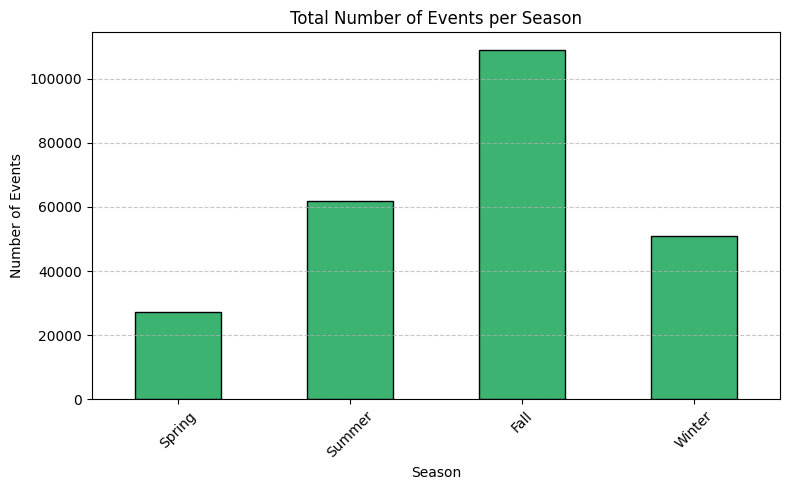

In [45]:



season_counts = df['season'].value_counts().reindex(['Spring', 'Summer', 'Fall', 'Winter'])


plt.figure(figsize=(8, 5))
season_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')

plt.title("Total Number of Events per Season")
plt.xlabel("Season")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

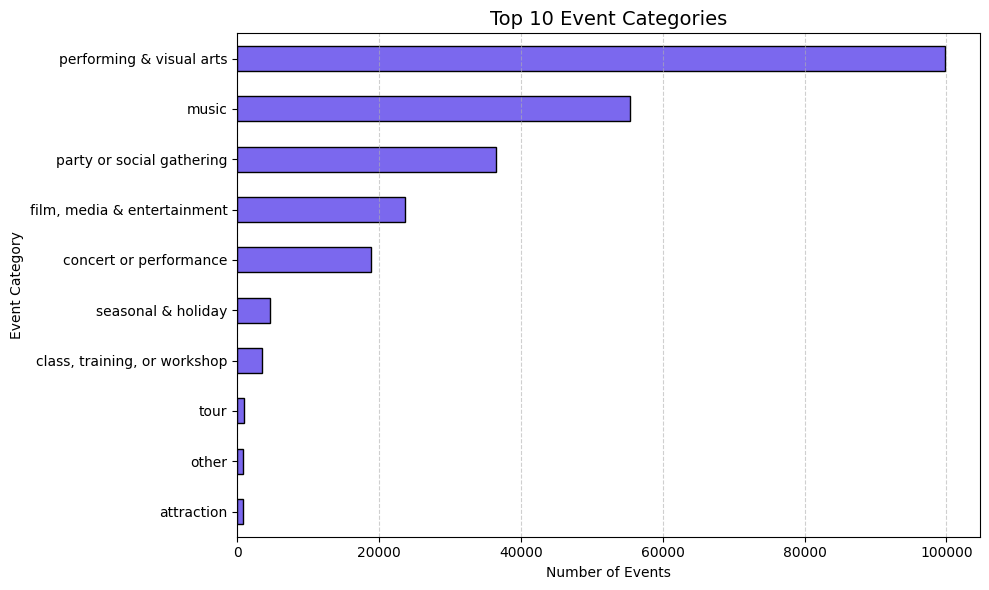

In [88]:



top_categories = df['event_category'].value_counts().head(10)


top_categories = top_categories.sort_values()


plt.figure(figsize=(10, 6))
top_categories.plot(kind='barh', color='mediumslateblue', edgecolor='black')

plt.title("Top 10 Event Categories", fontsize=14)
plt.xlabel("Number of Events")
plt.ylabel("Event Category")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

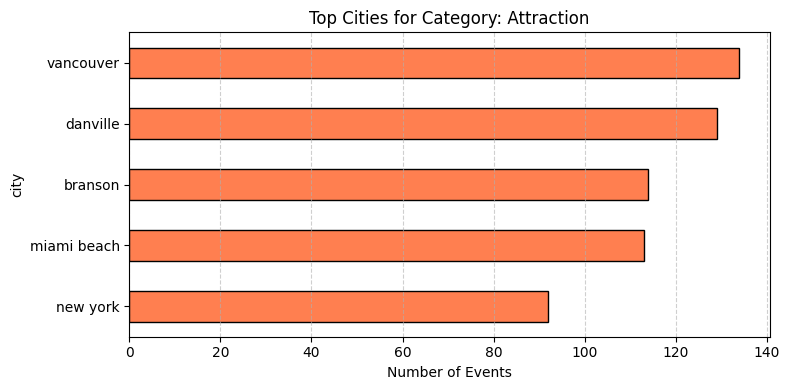

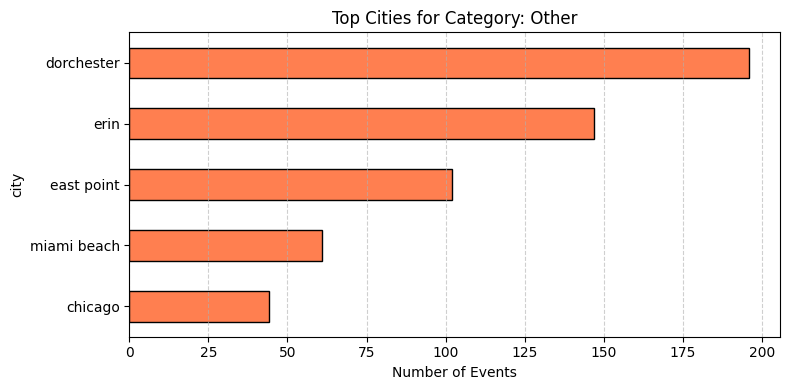

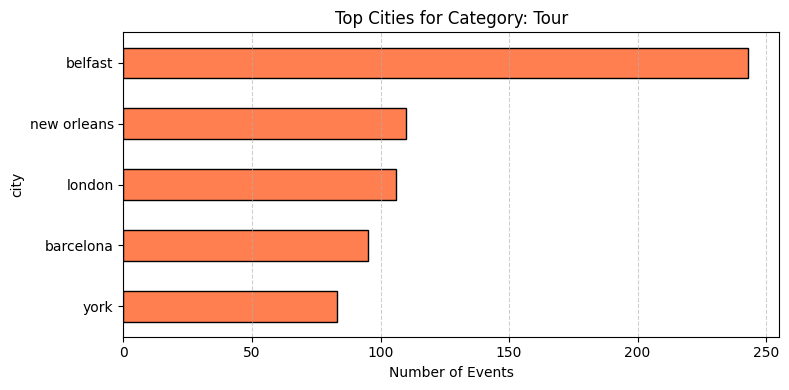

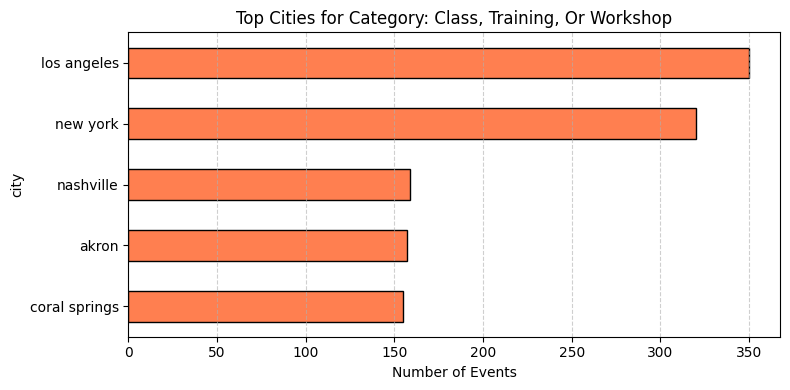

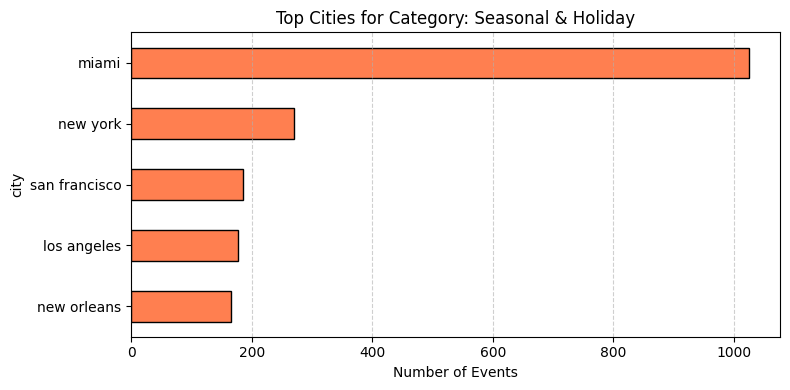

In [89]:
# Top N categories to check 
top_cat_list = top_categories.index[:5]

for cat in top_cat_list:
    city_counts = df[df['event_category'] == cat]['city'].value_counts().head(5)

    plt.figure(figsize=(8, 4))
    city_counts.plot(kind='barh', color='coral', edgecolor='black')
    plt.title(f"Top Cities for Category: {cat.title()}")
    plt.xlabel("Number of Events")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

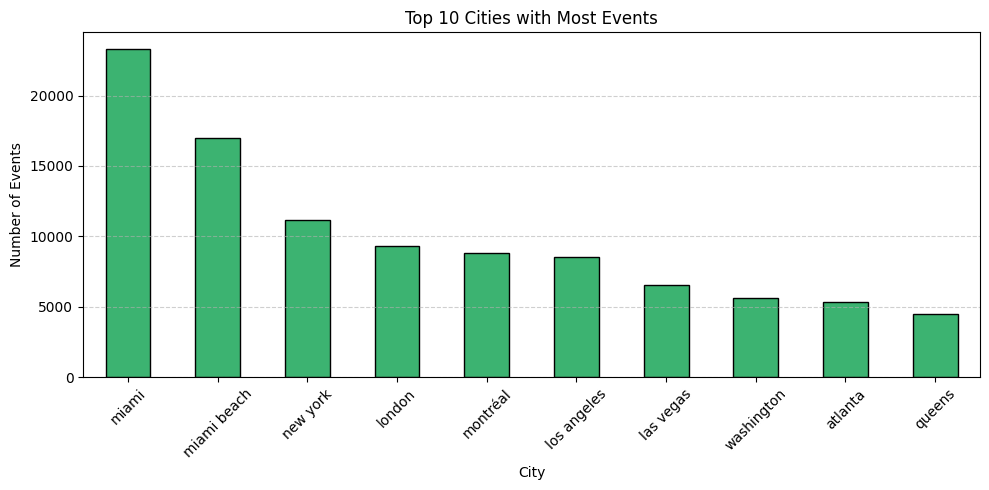

In [48]:
top_cities = df['city'].value_counts().head(10)

plt.figure(figsize=(10, 5))
top_cities.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.title("Top 10 Cities with Most Events")
plt.xlabel("City")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [49]:



city_matrix = pd.crosstab(df['event_category'], df['city'])


season_matrix = pd.crosstab(df['event_category'], df['season'])


city_matrix_norm = pd.DataFrame(normalize(city_matrix, norm='l1'),
                                 index=city_matrix.index,
                                 columns=city_matrix.columns)

season_matrix_norm = pd.DataFrame(normalize(season_matrix, norm='l1'),
                                   index=season_matrix.index,
                                   columns=season_matrix.columns)


combined_matrix = pd.concat([city_matrix_norm, season_matrix_norm], axis=1)



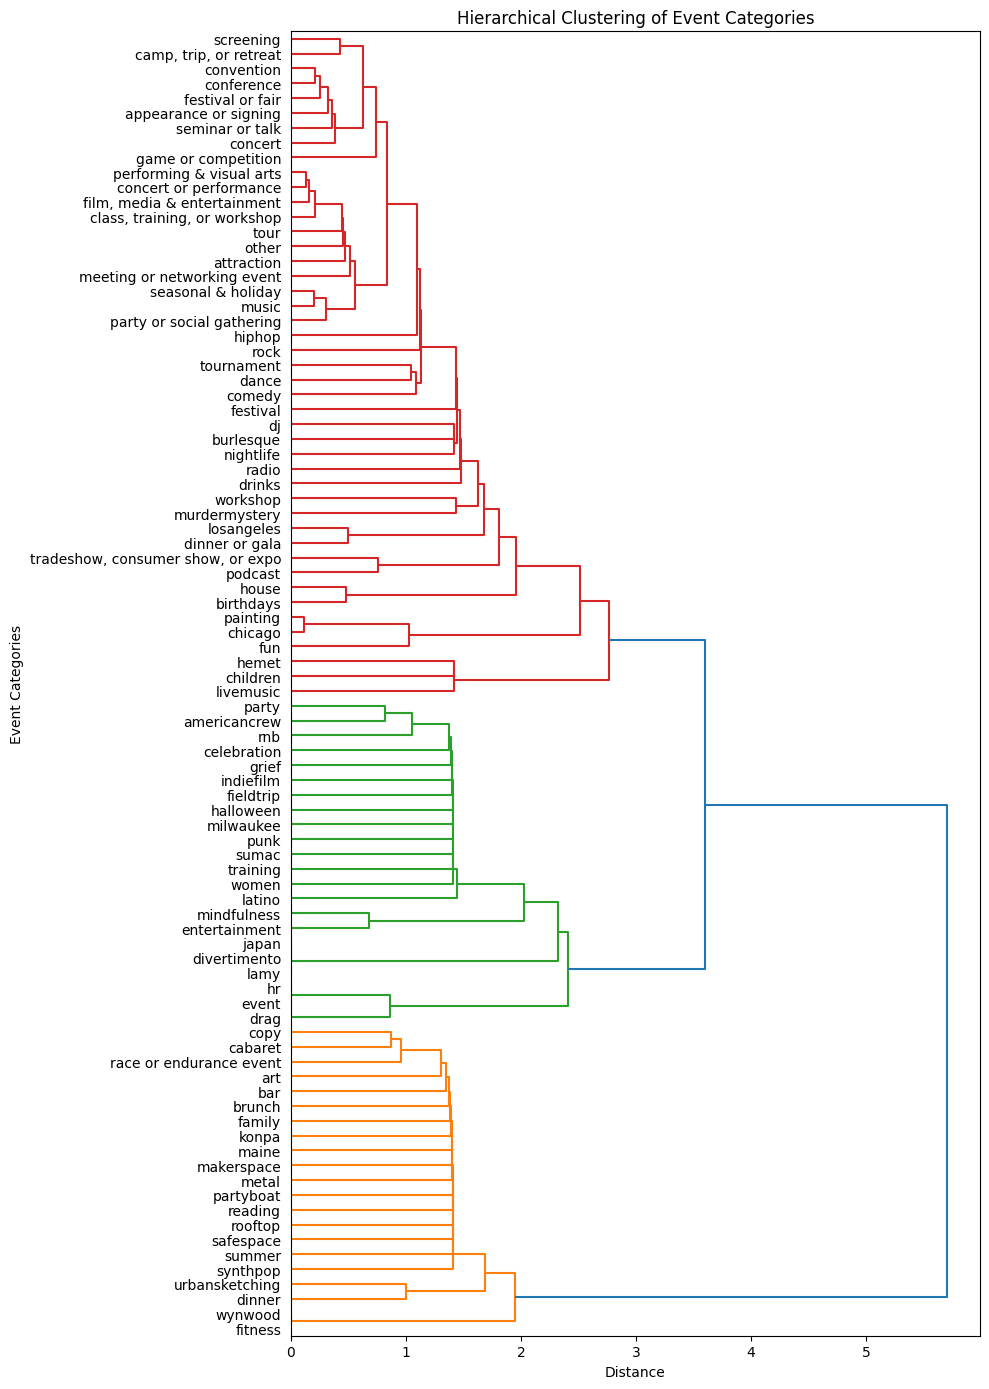

In [94]:
# linkage_matrix assumed to already be defined
plt.figure(figsize=(10, 14))  # Flip width and height for horizontal layout

dendrogram(
    linkage_matrix,
    labels=combined_matrix.index,
    orientation='right',  # THIS rotates the tree
    leaf_font_size=10,
    color_threshold=0.5 * max(linkage_matrix[:, 2])
)

plt.title("Hierarchical Clustering of Event Categories")
plt.xlabel("Distance")  # Now horizontal axis is distance
plt.ylabel("Event Categories")
plt.tight_layout()
plt.show()

In [66]:



num_clusters = 3


cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')


category_clusters = pd.DataFrame({
    'category': combined_matrix.index,
    'cluster': cluster_labels
})

category_clusters.sort_values('cluster', inplace=True)
print(category_clusters)

      category  cluster
87     wynwood        1
29      family        1
45       konpa        1
50       maine        1
51  makerspace        1
..         ...      ...
59       other        3
60    painting        3
35         fun        3
24          dj        3
18  convention        3

[88 rows x 2 columns]


In [68]:

df = df.drop(columns=[col for col in df.columns if col.startswith('cluster') or col.startswith('category_')],
              errors='ignore')  # ignore errors if any column doesn't exist


df = df.merge(category_clusters[['category', 'cluster']],
              left_on='event_category', right_on='category',
              how='left')


cluster_counts = df['cluster'].value_counts().sort_index()


print("Number of activities per cluster:")
print(cluster_counts)

Number of activities per cluster:
cluster
1.0        39
2.0        66
3.0    248780
Name: count, dtype: int64


In [60]:
df

,event_url,event_id,event_category,event_subcategory,title,datetime_local,name,address,city,state,...,year,month,day_of_week,is_weekend,season,cluster_x,category_x,cluster_y,category_y,cluster
0,https://www.eventbrite.com/e/brown-sugar-wedne...,684840996857,music,r&b,"BROWN SUGAR WEDNESDAY:""LA'S #1 MIDWEEK VIBE""w/...",2023-08-02 22:00:00,The Continental Club,116 West 4th Street,los angeles,ca,...,2023,8,Wednesday,False,Summer,0,music,3.0,music,3.0
1,https://www.eventbrite.com/e/we-love-tequila-w...,628715634387,music,top 40,We Love Tequila Wednesday’s EVERY BODY FREE TI...,2023-08-02 22:00:00,Love & Tequila,20 West Adams Avenue,detroit,mi,...,2023,8,Wednesday,False,Summer,0,music,3.0,music,3.0
2,https://www.eventbrite.com/e/brown-sugar-wedne...,643792168707,music,r&b,BROWN SUGAR WEDNESDAY: MIDWEEK PARTY EXPERIENCE,2023-08-02 22:00:00,The Continental Club,116 4th Street,los angeles,ca,...,2023,8,Wednesday,False,Summer,0,music,3.0,music,3.0
3,https://www.eventbrite.com/e/slutty-wednesdays...,613499091297,music,hip hop / rap,SLUTTY WEDNESDAYS,2023-08-02 22:00:00,NEW ADDRESS,1 william holmes borders sr dr ne,atlanta,ga,...,2023,8,Wednesday,False,Summer,0,music,3.0,music,3.0
4,https://www.eventbrite.com/e/the-spazmatics-th...,662612219987,concert or performance,music,The Spazmatics @ The Ballroom at Speakeasy,2023-08-02 20:00:00,Speakeasy,412 Congress Avenue,austin,tx,...,2023,8,Wednesday,False,Summer,0,concert or performance,3.0,concert or performance,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248997,https://www.eventbrite.com/e/the-5-comedy-show...,628025941497,performing & visual arts,comedy,The $5 Comedy Show,2026-08-06 20:00:00,The Gimmick,2213 East 6th Avenue,tampa,fl,...,2026,8,Thursday,False,Summer,0,performing & visual arts,3.0,performing & visual arts,3.0
248998,https://www.eventbrite.co.uk/e/all-levels-life...,637223260927,performing & visual arts,fine art,All-Levels Life Drawing in Central London with...,2026-08-06 18:30:00,8 Hop Gardens,8 Hop Gardens,london,england,...,2026,8,Thursday,False,Summer,3,performing & visual arts,3.0,performing & visual arts,3.0
248999,https://www.eventbrite.com/e/5-after-5-thursda...,572025121537,performing & visual arts,fine art,$5 After 5 Thursdays,2026-08-06 17:00:00,1901 Central Ave,1901 Central Avenue,st. petersburg,fl,...,2026,8,Thursday,False,Summer,0,performing & visual arts,3.0,performing & visual arts,3.0
249000,https://www.eventbrite.ca/e/free-online-paint-...,553934160987,performing & visual arts,painting,Free Online Paint Nite For Adults - Fontana,2026-08-06 17:00:00,Palak StudioInk,Online Art Classes,fontana,ca,...,2026,8,Thursday,False,Summer,0,performing & visual arts,3.0,performing & visual arts,3.0


In [84]:



df = df.dropna(subset=['cluster'])
df['cluster'] = df['cluster'].astype(int)


presence_matrix = df_filtered.groupby(['city', 'cluster']).size().unstack(fill_value=0)
presence_matrix[presence_matrix > 0] = 1  # convert to 1/0

presence_matrix.reset_index(inplace=True)

In [85]:
city_coords = df[['city', 'latitude', 'longitude']].drop_duplicates()

city_presence = presence_matrix.merge(city_coords, on='city', how='left')

In [86]:



cluster_colors = {
    1: 'orange',
    2: 'green',
    3: 'red'
}




m = folium.Map(location=[39.5, -98.35], zoom_start=4)

for _, row in city_presence.iterrows():

    present_clusters = [c for c in [1, 2, 3] if row.get(c, 0) == 1]
    

    if 1 in present_clusters:
        color = cluster_colors[1]
    elif 2 in present_clusters:
        color = cluster_colors[2]
    elif 3 in present_clusters:
        color = cluster_colors[3]
    else:
        color = 'blue'  # in case none are present


    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['city']} — Clusters: {', '.join(map(str, present_clusters))}"
    ).add_to(m)


m.save("cluster_priority_map.html")

In [87]:

category_counts = df.groupby(['cluster', 'event_category']).size().reset_index(name='event_count')


top_categories = category_counts.sort_values('event_count', ascending=False).groupby('cluster').first().reset_index()


top_categories.columns = ['cluster', 'top_category', 'event_count']

print(top_categories)

   cluster              top_category  event_count
0        1   race or endurance event            6
1        2             entertainment           27
2        3  performing & visual arts        99751


In [92]:
df

,event_url,event_id,event_category,event_subcategory,title,datetime_local,name,address,city,state,...,latitude,longitude,year,month,day_of_week,is_weekend,season,category_x,category_y,cluster
0,https://www.eventbrite.com/e/brown-sugar-wedne...,684840996857,music,r&b,"BROWN SUGAR WEDNESDAY:""LA'S #1 MIDWEEK VIBE""w/...",2023-08-02 22:00:00,The Continental Club,116 West 4th Street,los angeles,ca,...,34.053691,-118.242766,2023,8,Wednesday,False,Summer,music,music,3
1,https://www.eventbrite.com/e/we-love-tequila-w...,628715634387,music,top 40,We Love Tequila Wednesday’s EVERY BODY FREE TI...,2023-08-02 22:00:00,Love & Tequila,20 West Adams Avenue,detroit,mi,...,42.331551,-83.046640,2023,8,Wednesday,False,Summer,music,music,3
2,https://www.eventbrite.com/e/brown-sugar-wedne...,643792168707,music,r&b,BROWN SUGAR WEDNESDAY: MIDWEEK PARTY EXPERIENCE,2023-08-02 22:00:00,The Continental Club,116 4th Street,los angeles,ca,...,34.053691,-118.242766,2023,8,Wednesday,False,Summer,music,music,3
3,https://www.eventbrite.com/e/slutty-wednesdays...,613499091297,music,hip hop / rap,SLUTTY WEDNESDAYS,2023-08-02 22:00:00,NEW ADDRESS,1 william holmes borders sr dr ne,atlanta,ga,...,33.748992,-84.390264,2023,8,Wednesday,False,Summer,music,music,3
4,https://www.eventbrite.com/e/the-spazmatics-th...,662612219987,concert or performance,music,The Spazmatics @ The Ballroom at Speakeasy,2023-08-02 20:00:00,Speakeasy,412 Congress Avenue,austin,tx,...,30.271129,-97.743700,2023,8,Wednesday,False,Summer,concert or performance,concert or performance,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248997,https://www.eventbrite.com/e/the-5-comedy-show...,628025941497,performing & visual arts,comedy,The $5 Comedy Show,2026-08-06 20:00:00,The Gimmick,2213 East 6th Avenue,tampa,fl,...,27.947760,-82.458444,2026,8,Thursday,False,Summer,performing & visual arts,performing & visual arts,3
248998,https://www.eventbrite.co.uk/e/all-levels-life...,637223260927,performing & visual arts,fine art,All-Levels Life Drawing in Central London with...,2026-08-06 18:30:00,8 Hop Gardens,8 Hop Gardens,london,england,...,51.378394,-0.102106,2026,8,Thursday,False,Summer,performing & visual arts,performing & visual arts,3
248999,https://www.eventbrite.com/e/5-after-5-thursda...,572025121537,performing & visual arts,fine art,$5 After 5 Thursdays,2026-08-06 17:00:00,1901 Central Ave,1901 Central Avenue,st. petersburg,fl,...,27.770048,-82.635908,2026,8,Thursday,False,Summer,performing & visual arts,performing & visual arts,3
249000,https://www.eventbrite.ca/e/free-online-paint-...,553934160987,performing & visual arts,painting,Free Online Paint Nite For Adults - Fontana,2026-08-06 17:00:00,Palak StudioInk,Online Art Classes,fontana,ca,...,34.092295,-117.434330,2026,8,Thursday,False,Summer,performing & visual arts,performing & visual arts,3


In [93]:



cluster_colors = {
    1: 'orange',
    2: 'green',
    3: 'red'
}


season_labels = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}


for season in sorted(df['season'].unique()):
    season_df = df[df['season'] == season].copy()


    grouped = season_df.groupby(['city', 'cluster']).size().unstack(fill_value=0)
    grouped[grouped > 0] = 1  # Binary presence

    grouped.reset_index(inplace=True)


    city_coords = season_df[['city', 'latitude', 'longitude']].drop_duplicates(subset=['city'])
    city_presence = grouped.merge(city_coords, on='city', how='left').dropna()


    m = folium.Map(location=[39.5, -98.35], zoom_start=4)

    for _, row in city_presence.iterrows():
        present_clusters = [c for c in [1, 2, 3] if row.get(c, 0) == 1]


        if 1 in present_clusters:
            color = cluster_colors[1]
        elif 2 in present_clusters:
            color = cluster_colors[2]
        elif 3 in present_clusters:
            color = cluster_colors[3]
        else:
            color = 'blue'

        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=6,
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=f"{row['city'].title()} — Clusters: {', '.join(map(str, present_clusters))}"
        ).add_to(m)

    label = season_labels.get(season, f"Season{season}")
    filename = f"cluster_priority_{label.lower()}.html"
    m.save(filename)
    print(f"{label} map saved as {filename}")

SeasonFall map saved as cluster_priority_seasonfall.html
SeasonSpring map saved as cluster_priority_seasonspring.html
SeasonSummer map saved as cluster_priority_seasonsummer.html
SeasonWinter map saved as cluster_priority_seasonwinter.html
